In [1]:
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import pprint
import os
from shutil import copyfile
from tqdm.notebook import tqdm
import pandas as pd
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import unsharp_mask

import numpy as np
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# test model performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Load data

In [2]:
def random_crop(x, y, size, number, dims=1):
    x_result = None
    y_result = None
    max_index = len(x)
    
    
    for i in tqdm(range(max_index)):
        final_number = int(float(x[i].shape[0] * x[i].shape[1]) / (400. * 400.) * float(number))

        x_crop = extract_patches_2d(x[i], (size,size), final_number, i*100)
        y_crop = extract_patches_2d(y[i], (size,size), final_number, i*100)
                
        
        if x_result is None:
            x_result = x_crop
            y_result = y_crop
        else:
            x_result = np.concatenate((x_result, x_crop))
            y_result = np.concatenate((y_result, y_crop))
    
    x_result = np.expand_dims(x_result, axis=-1)
    y_result = np.expand_dims(y_result, axis=-1)
    return x_result, y_result

In [3]:
data_dir = Path('./data/BCD')
df = pd.read_csv(data_dir / 'metadata.csv')

ids = np.unique(df['id'].values)
sharpen_img_dir = data_dir / 'sharpen_area_img'
proximity_img_dir = data_dir / 'proximity_area_map'

img_data = []
mask_data = []
coord_data = []

for single_id in tqdm(ids, total=len(ids)):
    try:
        single_df = df[df['id'] == single_id]

        centroids = np.transpose(np.stack((single_df['centroid_x'].values, single_df['centroid_y'].values)))

#         img = np.load(sharpen_img_dir / '{:03d}.npy'.format(single_id))
        img = np.array(Image.open(sharpen_img_dir / '{:03d}.jpg'.format(single_id)))

        mask = np.loadtxt(proximity_img_dir / '{:03d}.csv'.format(single_id), delimiter=',')

        img_data.append(img)
        mask_data.append(mask)
        coord_data.append(centroids)
    except:
        continue

print(len(img_data), len(mask_data), len(coord_data))
print(img_data[0].shape, mask_data[0].shape, coord_data[0].shape)

for i in range(len(img_data)):
    if img_data[i].shape[-1] < 4:
        img_data[i] = img_data[i][:, :, 0]
        
train_index = [0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37 ]
val_index = [5, 6, 16, 17, 27, 28, 38, 39]
test_index = [7, 8, 18, 19, 29, 30, 40, 41]

train_data = []
train_mask = []

test_data = []
test_mask = []

val_data = []
val_mask = []


for index in train_index:
    train_data.append(img_data[index])
    train_mask.append(mask_data[index])
    
for index in val_index:
    val_data.append(img_data[index])
    val_mask.append(mask_data[index])
    
for index in test_index:
    test_data.append(img_data[index])
    test_mask.append(mask_data[index])


42 42 42
(449, 311) (449, 311) (51, 2)


In [4]:
size = 128
X_train, y_train = random_crop(train_data, train_mask, size, 100)
print(X_train.shape, y_train.shape)

X_val, y_val = random_crop(val_data, val_mask, size, 100)
print(X_val.shape, y_val.shape)


(2335, 128, 128, 1) (2335, 128, 128, 1)



(755, 128, 128, 1) (755, 128, 128, 1)


1.0 1.0
1.0


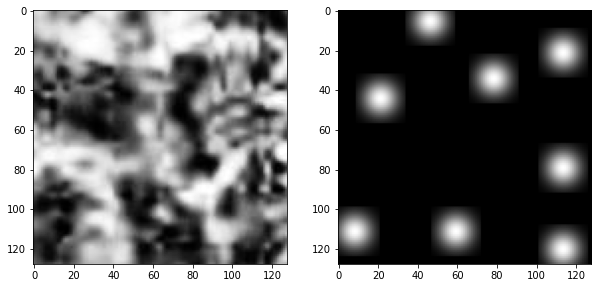

In [5]:
sample_nun = np.random.randint(low=0, high=len(X_train))
resize_x = np.resize(X_train[sample_nun], (size, size))
x_img = Image.fromarray(resize_x)
resize_y = np.resize(y_train[sample_nun], (size, size))
print(np.max(resize_y), np.max(y_train[sample_nun]))
scale_y = resize_y * (255./np.max(resize_y))
y_img = Image.fromarray(scale_y.astype('uint8'))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x_img, cmap='gray')
axs[1].imshow(y_img, cmap='gray')

print(np.max(y_train[0].flatten()))

In [6]:
batch_size = 32

data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True,
                    vertical_flip=True, rotation_range=180)
mask_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=180)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

image_datagen.fit(X_train)
mask_datagen.fit(y_train)

seed = 100
image_generator = image_datagen.flow(X_train, seed=seed, batch_size=batch_size, shuffle=True)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=batch_size, shuffle=True)
train_generator = (pair for pair in zip(image_generator, mask_generator))

val_data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True, horizontal_flip=True,
                    vertical_flip=True, rotation_range=180)
val_mask_gen_args = dict(horizontal_flip=True, vertical_flip=True, rotation_range=180)

val_image_datagen = ImageDataGenerator(**val_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_mask_gen_args)

val_image_datagen.fit(X_val)
val_mask_datagen.fit(y_val)

seed = 100
val_image_generator = val_image_datagen.flow(X_val, seed=seed, batch_size=32, shuffle=True)
val_mask_generator = val_mask_datagen.flow(y_val, seed=seed, batch_size=32, shuffle=True)
val_generator = (pair for pair in zip(val_image_generator, val_mask_generator))

# Vnet model

In [7]:
from tensorflow.keras import optimizers, initializers, regularizers

def prepare_vnet_encoder(config, inputs, trainable=True):
    prev_output = inputs
    regularizer = regularizers.l2(0.001)
    save_layers = []
    
    
    for i in range(len(config)):
        layer_prev_output = prev_output
        for j in range(config[i][1]):
            c = layers.Conv2D(config[i][0], (5, 5), kernel_initializer='he_normal',
                              trainable=trainable, kernel_regularizer=regularizer,
                              padding='same', name='dw_c{}_{}'.format(i, j))(prev_output)
            
            # skip connection
            if j == config[i][1] - 1 and i != 0:
                c = layers.Add()([c, layer_prev_output])
              
            c = layers.Activation('elu')(c)
            c = tf.keras.layers.BatchNormalization()(c)
                
            prev_output = c
        
        # down convolution
        if i != len(config) -1:
            save_layers.append(c)
            c = layers.Conv2D(config[i][0] * 2, (2, 2), strides=2, kernel_initializer='he_normal',
                              trainable=trainable, kernel_regularizer=regularizer, activation='elu',
                              padding='same', name='p_cd{}_{}'.format(i, j))(c)
            c = tf.keras.layers.BatchNormalization()(c)
            prev_output = c
    
    return prev_output, save_layers
        
def prepare_vnet_decoder(config, inputs, skip_layers, trainable=True):
    prev_output = inputs
    regularizer = regularizers.l2(0.001)
    
    for i in range(len(config)):
        # up deconvolution
        u = layers.Conv2DTranspose(config[i][0], (2, 2), strides=(2, 2), activation='elu',
                                   kernel_initializer='he_normal', trainable=trainable,
                                   padding='same', name='up_u{}_1'.format(i))(prev_output)
        u = tf.keras.layers.BatchNormalization()(u)
        layer_prev_output = u
        prev_output = u        
        for j in range(config[i][1]):
            # long skip connection
            if j == 0:
                c = layers.concatenate([prev_output, skip_layers[-(i+1)]])
            else:
                c = prev_output

            c = layers.Conv2D(config[i][0], (5, 5), kernel_initializer='he_normal', trainable=trainable,
                            kernel_regularizer=regularizer, padding='same', name='up_cd{}_{}'.format(i, j))(c)
            
            # short skip connection
            if j == config[i][1] -1:
                c = layers.Add()([c, layer_prev_output])
            
            c = layers.Activation('elu')(c)
            c = tf.keras.layers.BatchNormalization()(c)
                
        prev_output = c
        
    return prev_output
        
def prepare_vnet(config, weight_path=None):
    input_shape = config['input_size']
    output_size = config['output_size']
    loss_function = config['loss_function']
    

    #Build the model
    inputs = tf.keras.layers.Input(input_shape)
    
    encoder_config = [[16, 1], [32, 2], [64, 3], [128, 3], [256, 3]]
    encoder, skip_layers = prepare_vnet_encoder(encoder_config, inputs)
    
    decoder_config = [[128, 3], [64, 3], [32, 2], [16, 1]]
    decoder = prepare_vnet_decoder(decoder_config, encoder, skip_layers)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder)
    full_model = keras.Model(inputs=inputs,
                             outputs=outputs)

    if weight_path is not None:
        full_model.load_weights(weight_path)

    full_model.compile(optimizer='adam',
                       loss=loss_function,
                       metrics=['mae'])
    return full_model

size = 128
test_config={
    "input_size": (size, size, 1),
    "output_size": (size, size, 1),
    "loss_function": 'mse'
}


model = None
model = prepare_vnet(test_config)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
dw_c0_0 (Conv2D)                (None, 128, 128, 16) 416         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           dw_c0_0[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          activation[0][0]                 
______________________________________________________________________________________________

# Train

In [8]:
from tensorflow.python.ops import array_ops, math_ops
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau


def dice_coef(y_true, y_pred, smooth=2e-126):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

size = 128

config={
    "input_size": (size, size, 1),
    "output_size": (size, size, 1),
    "loss_function": dice_coef_loss
}

early_stop = keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=3, min_lr=0.000)

model = None
model = prepare_vnet(config)
model.fit(train_generator, steps_per_epoch=int(np.ceil(len(X_train)/32)), callbacks=[early_stop, reduce_lr],
                    epochs=1000, validation_data=val_generator, validation_steps=int(np.ceil(len(X_val)/32)))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 73 steps, validate for 24 steps
Epoch 1/1000
73/73 [==============================] - 10s 136ms/step - loss: 1.7761 - mae: 0.3320 - val_loss: 0.9726 - val_mae: 0.1494
Epoch 2/1000
73/73 [==============================] - 5s 72ms/step - loss: 0.6709 - mae: 0.2475 - val_loss: 0.8791 - val_mae: 0.1440
Epoch 3/1000
73/73 [==============================] - 5s 73ms/step - loss: 0.5457 - mae: 0.2221 - val_loss: 0.7918 - val_mae: 0.1536
Epoch 4/1000
73/73 [==============================] - 6s 79ms/step - loss: 0.5055 - mae: 0.2173 - val_loss: 0.7338 - val_mae: 0.1577
Epoch 5/1000
73/73 [==============================] - 5s 72ms/step - loss: 0.4697 - mae: 0.2101 - val_loss: 0.5985 - val_mae: 0.2022
Epoch 6/1000
73/73 [==============================] - 5s 71ms/step - loss: 0.4578 - mae: 0.2068 - val_loss: 0.6930 - val_mae: 0.1638
Epoch 7/1000
73/73 [==============================] - 5s 74ms/step - loss: 0.4661 - mae: 0.2084 - val_loss: 

In [9]:
model_dir = Path('./models')
os.makedirs(model_dir, exist_ok=True)
model.save(model_dir / 'BCD_model.h5')

# Post processing

## Load data

In [14]:
data_dir = Path('./data/BCD')
df = pd.read_csv(data_dir / 'metadata.csv')
model_dir = Path('./models')
model = load_model(model_dir / 'BCD_micai_area_val_loss.h5', compile=False)

ids = np.unique(df['id'].values)
sharpen_img_dir = data_dir / 'sharpen_area_img'
original_img_dir = data_dir / 'upscale_area_img'

proximity_img_dir = data_dir / 'proximity_area_map'

original_img_data = []
img_data = []
mask_data = []
coord_data = []

for single_id in tqdm(ids, total=len(ids)):
    try:
        single_df = df[df['id'] == single_id]

        centroids = np.transpose(np.stack((single_df['centroid_x'].values, single_df['centroid_y'].values)))

        img = Image.open(sharpen_img_dir / '{:03d}.jpg'.format(single_id))
        img = np.array(img)
        
        original_img = Image.open(original_img_dir / '{:03d}.jpg'.format(single_id))
        original_img = np.array(original_img)

        mask = np.loadtxt(proximity_img_dir / '{:03d}.csv'.format(single_id), delimiter = ',')

        original_img_data.append(original_img)
        img_data.append(img)
        mask_data.append(mask)
        coord_data.append(centroids)
    except:
        continue


for i in range(len(img_data)):
    if img_data[i].shape[-1] < 4:
        img_data[i] = img_data[i][:, :, 0]
        
test_index = [7, 8, 17, 18, 28, 29]


test_data = []
test_original_data = []
test_mask = []
    
for index in test_index:
    test_data.append(img_data[index])
    test_mask.append(mask_data[index])
    test_original_data.append(original_img_data[index])
    
test_coord = []

for index in test_index:
    test_coord.append(coord_data[index])

## Generate prediction

In [15]:
def generate_image_patches(img, size):
    max_x = int(np.ceil(img.shape[0]/ size))
    max_y = int(np.ceil(img.shape[1]/ size))
    
    if max_x == 1:
        x_interval = 0
    else:
        x_interval = ((img.shape[0] - size/2.) - (size/2.)) / (max_x-1)
    
    if max_y == 1:
        y_interval = 0
    else:
        y_interval = ((img.shape[1] - size/2.) - (size/2.)) / (max_y-1)
    
    center_coords = []
    
    for i in range(max_x):
        for j in range(max_y):
            if i == 0:
                x = int(size/2.)
            elif i == max_x - 1:
                x = int(img.shape[0] - size/2.)
            else:
                x = int(size/2. + i * x_interval)
            
            if j == 0:
                y = int(size/2.)
            elif j == max_y -1:
                y = int(img.shape[1] - size/2.)
            else:
                y = int(size/2. + j * y_interval)
                
            center_coords.append([x,y])
            
    ones_array = np.full((size, size), 1.)
    weight_array = np.full((img.shape), 0.)

    image_patches = []
    for i in range(len(center_coords)):
        weight_array[center_coords[i][0] - int(size/2.): center_coords[i][0] + int(size/2.), center_coords[i][1] - int(size/2.): center_coords[i][1] + int(size/2.)] += ones_array
        image_patches.append(img[center_coords[i][0] - int(size/2.): center_coords[i][0] + int(size/2.), center_coords[i][1] - int(size/2.): center_coords[i][1] + int(size/2.)])
        
    weight_array = 1./weight_array
    
    return image_patches, center_coords, weight_array

def reconstruct_image_patches(image_patches, center_coords, size, weight_array):
    reconstruct_img = np.full(weight_array.shape, 0.)
    for i in range(len(image_patches)):
        reconstruct_img[center_coords[i][0] - int(size/2.): center_coords[i][0] + int(size/2.),
                   center_coords[i][1] - int(size/2.): center_coords[i][1] + int(size/2.)] += image_patches[i]
    
    reconstruct_img = np.multiply(reconstruct_img, weight_array)
    return reconstruct_img

In [16]:
import time
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
patch_size = 128
model = None
model_dir = Path('./models')
model = load_model(model_dir / 'BCD_model.h5', compile=False)
test_data_path = Path('./data/test_data.h5')

with h5py.File(test_data_path, 'w') as file:
    for k in tqdm(range(len(test_data))):
        sample_num = k
        image_patches, center_coords, weight_array = generate_image_patches(test_data[sample_num], patch_size)
        resize_image_patches = []
        xy_offset = []

        for i in range(len(image_patches)):
            resize_image_patches.append(np.resize(image_patches[i], (patch_size, patch_size, 1)))
            xy_offset.append([center_coords[i][0] - int(patch_size/2.), center_coords[i][1] - int(patch_size/2.)])

        resize_image_patches = np.array(resize_image_patches)  
        xy_offset = np.array(xy_offset)

        test_data_gen_args = dict(featurewise_center=True, featurewise_std_normalization=True)
        test_image_datagen = ImageDataGenerator(**test_data_gen_args)
        test_image_datagen.fit(resize_image_patches)
        test_image_generator = test_image_datagen.flow(resize_image_patches, batch_size=1, shuffle=False)
        result = model.predict(test_image_generator)

        resize_result = np.resize(result, (len(result), patch_size, patch_size)) 
        
        file.create_dataset('processed/{:03}'.format(k), data=test_data[sample_num])
        file.create_dataset('original/{:03}'.format(k), data=test_original_data[sample_num])

        file.create_dataset('predict_patches/{:03}'.format(k), data=resize_result)
        file.create_dataset('ground_truth/{:03}'.format(k), data=test_mask[k])
        file.create_dataset('xy_offset/{:03}'.format(k), data=xy_offset)

In [17]:
from scipy.spatial import distance

def dist2(p1, p2):
    return (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2

def fuse(points, d):
    ret = []
    d2 = d * d
    n = len(points)
    taken = [False] * n
    for i in range(n):
        if not taken[i]:
            count = 1
            point = [points[i][0], points[i][1]]
            taken[i] = True
            for j in range(i+1, n):
                if dist2(points[i], points[j]) < d2:
                    point[0] += points[j][0]
                    point[1] += points[j][1]
                    count+=1
                    taken[j] = True
            point[0] /= count
            point[1] /= count
            ret.append((point[0], point[1]))
    ret = np.array(ret)
    return ret

def remove_edge_point(points, size, threshold=5.):
    result = []
    for i in points:
        if i[0] <= threshold or i[1] <= threshold or i[0] >= size[1]-threshold-1 or i[1] >= size[0]-threshold-1:
            continue
        result.append(i)
    return np.array(result)



def closest_node(node, nodes):
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index

def calculate_average_neareast_distance(y_pred, y_true, duplicate=True):
    distance = []
    holder = y_true.copy()
    for i in tqdm(range(len(y_pred)), leave=False):
        if(len(holder) == 0):
            break
        index = closest_node(y_pred[i], holder)
        distance.append(np.linalg.norm(y_pred[i] - holder[index]))
        
        if not duplicate:
            holder = np.delete(holder, index, axis=0)
        
    return np.mean(distance)


In [22]:
def full_test(sample_num, data_path, patch_size, graph=False):
    with h5py.File(test_data_path, 'r') as file:
        image_patches = file.get('predict_patches/{:03}'.format(sample_num))[:]
        image_patches = np.reshape(image_patches, (len(image_patches), patch_size, patch_size))
        original_img = file.get('original/{:03}'.format(sample_num))[:]
        processed_img = file.get('processed/{:03}'.format(sample_num))[:]

        ground_truth = file.get('ground_truth/{:03}'.format(sample_num))[:]
        xy_offset = file.get('xy_offset/{:03}'.format(sample_num))[:]
        
    centroid_locs = np.argwhere(ground_truth == 1.0)
    centroid_num = len(centroid_locs)
    
    neighborhood_size = 12
    threshold = 0.15

    global_coords = []
    
    distance_duplicate = []
    distance_non_duplicate = []
    
    for i in range(len(image_patches)):
        data = image_patches[i]
        data_max = filters.maximum_filter(data, neighborhood_size)
        maxima = (data == data_max)
        data_min = filters.minimum_filter(data, neighborhood_size)
        diff = ((data_max - data_min) > threshold)
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        coords = []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            y_center = (dy.start + dy.stop - 1)/2    
            coords.append([x_center, y_center])
            global_coords.append([x_center + xy_offset[i][1], y_center + xy_offset[i][0]])

        coords = np.array(coords)

    global_coords = np.array(global_coords)
    fuse_points = fuse(global_coords, 12)
    fuse_points = remove_edge_point(fuse_points, ground_truth.shape)
    
    distance_duplicate.append(calculate_average_neareast_distance(fuse_points, centroid_locs))
    distance_non_duplicate.append(calculate_average_neareast_distance(fuse_points, centroid_locs, False))
    
    if graph:
        X = np.arange(0, ground_truth.shape[0])
        Y = np.arange(0, ground_truth.shape[1])
        fig, axs = plt.subplots(1, 3, figsize=(21, 5))

        s = 3
        axs[1].contourf(Y, X, ground_truth, 100, cmap='Blues')
        axs[1].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r', s=s)
        axs[1].scatter(fuse_points[:, 0], fuse_points[:, 1], c='g', s=s)
        axs[1].set_xlim(0, ground_truth.shape[1])
        axs[1].set_ylim(0, ground_truth.shape[0])
        axs[1].set_title('Ground Truth')
        axs[1].set_aspect('equal')
    
        axs[0].contourf(Y, X, processed_img, 100, cmap='gray')
        axs[0].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r', s=s)
        axs[0].scatter(fuse_points[:, 0], fuse_points[:, 1], c='b', s=s)
        axs[0].set_xlim(0, ground_truth.shape[1])
        axs[0].set_ylim(0, ground_truth.shape[0])
        axs[0].set_title('Processed img')
        axs[0].set_aspect('equal')
        
        axs[2].contourf(Y, X, original_img[:, :, 0], 100, cmap='gray')
        axs[2].scatter(centroid_locs[:, 1], centroid_locs[:, 0], c='r', s=s)
        axs[2].scatter(fuse_points[:, 0], fuse_points[:, 1], c='b', s=s)
        axs[2].set_xlim(0, ground_truth.shape[1])
        axs[2].set_ylim(0, ground_truth.shape[0])
        axs[2].set_title('Original img'.format(len(fuse_points), centroid_num))
        axs[2].set_aspect('equal')
        
        fig.suptitle('Aggregate result: {}/{}'.format(len(fuse_points), centroid_num))

        plt.show()
        
        
        
        print(ground_truth.shape, original_img.shape)
        
    y_true = float(centroid_num)
    y_pred = float(len(fuse_points))
    
    error = np.abs(y_pred - y_true) / y_true * 100
    return len(fuse_points), centroid_num, error, np.mean(distance_duplicate), np.mean(distance_non_duplicate)

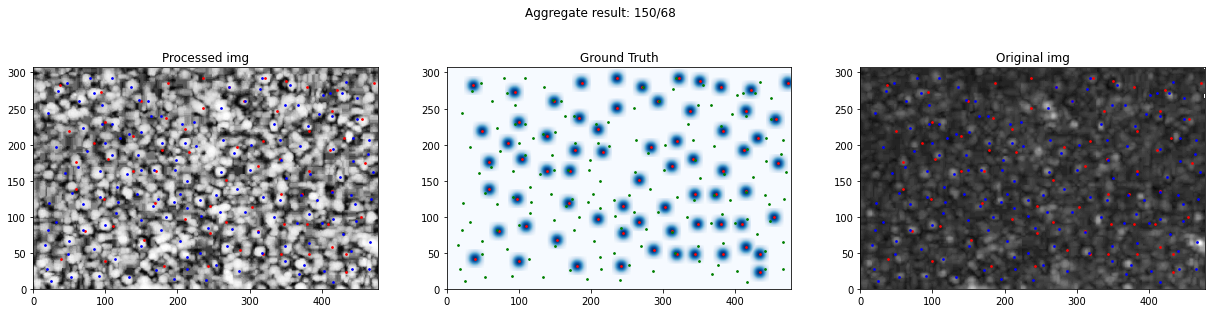

(307, 478) (307, 478, 3)


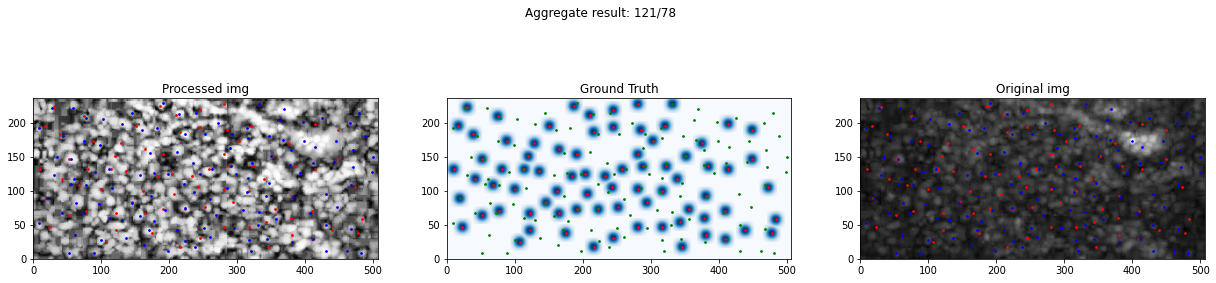

(236, 507) (236, 507, 3)


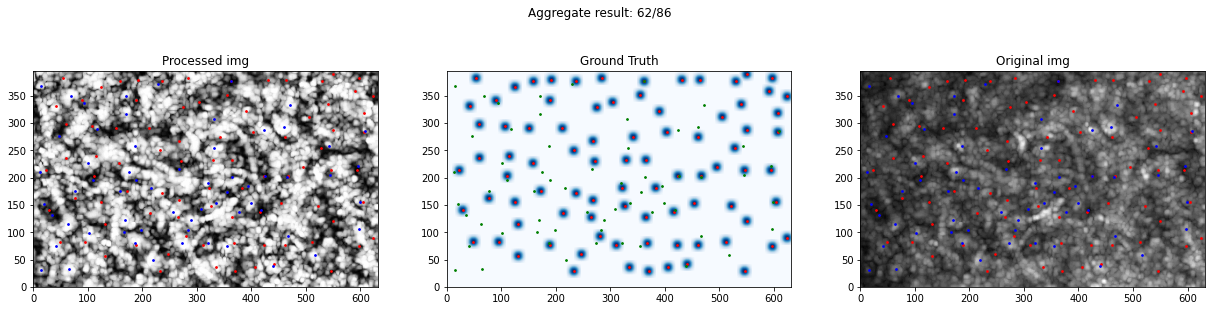

(396, 632) (396, 632, 3)


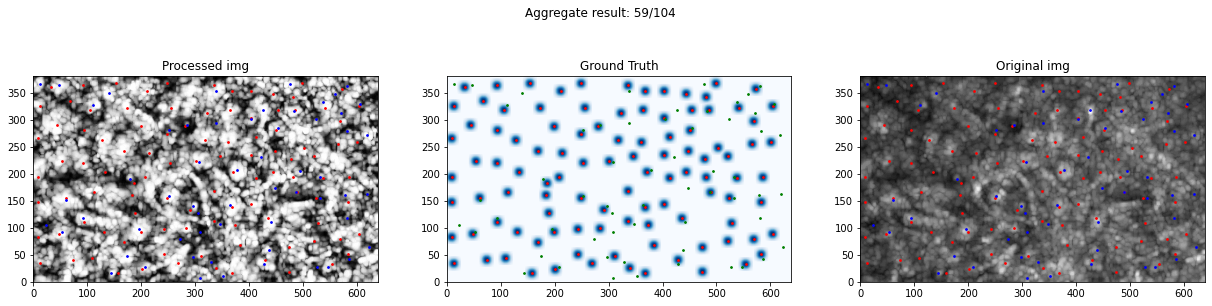

(381, 639) (381, 639, 3)


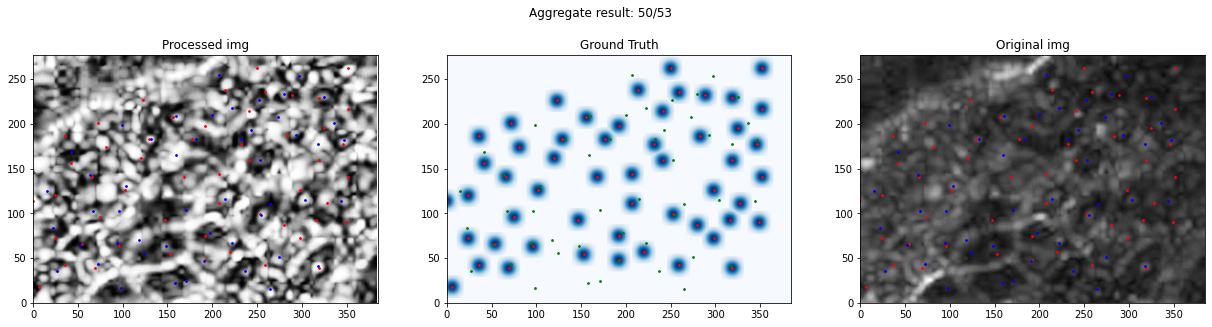

(277, 385) (277, 385, 3)


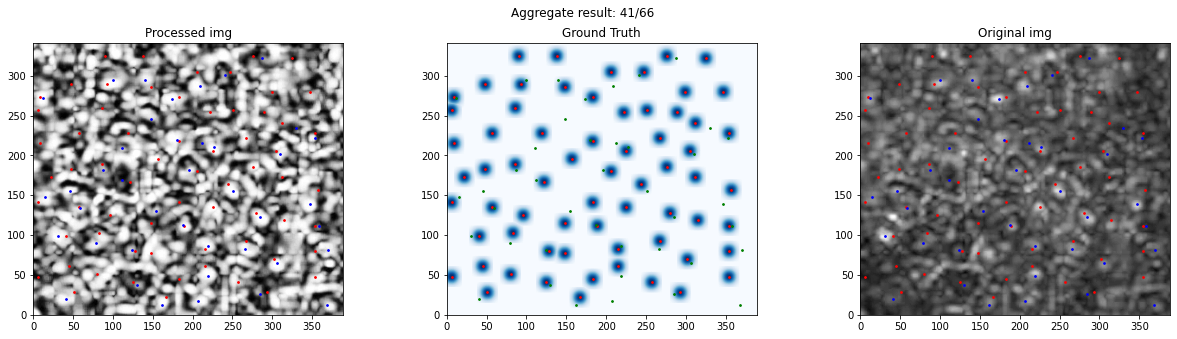

(341, 389) (341, 389, 3)

Avg error: 48.405302195503 std: 35.68395982685438
Avg duplicate distance error: 27.9754074609788 std: 12.02124608454619
Avg non duplicate distance error: 69.19055007029552 std: 32.688781898198954


In [23]:
acc = []
dis_dup = []
dis_non_dup = []
for i in tqdm(range(len(test_data))):
    result = full_test(i, test_data_path, patch_size, graph=True)
    acc.append(result[2])
    dis_dup.append(result[3])
    dis_non_dup.append(result[4])
    
acc = np.array(acc)
dis_dup = np.array(dis_dup) / 2
dis_non_dup = np.array(dis_non_dup) / 2.
print('Avg error: {} std: {}'.format(np.mean(acc), np.std(acc)))
print('Avg duplicate distance error: {} std: {}'.format(np.mean(dis_dup),np.std(dis_dup)))
print('Avg non duplicate distance error: {} std: {}'.format(np.mean(dis_non_dup), np.std(dis_non_dup)))